## Fine‑tuning (Debemos usar CUDA!!)
Vamos a entrenar YOLOv8 en un conjunto pequeño de datos usando la API Ultralytics. Hay que ajustar las rutas y parámetros según el dataset.

Como de costumbre: Primero, instalemos ultralytics

In [ ]:
!pip -q install ultralytics # Instalamos Ultralytics (nos permitirá usar YOLO)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.9 MB/s eta 0:00:00


## 1. Subamos `datasets.zip` y `bccd.yaml` (archivo de configuración) al Google Colab

## 2. Descomprimimos `dataset.zip`

In [ ]:
!unzip datasets.zip

Archive:  datasets.zip
   creating: datasets/
   creating: datasets/BCCD/
   creating: datasets/BCCD/labels/
   creating: datasets/BCCD/labels/train/
  inflating: datasets/BCCD/labels/train/BloodImage_00339.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00287.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00107.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00305.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00089.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00311.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00199.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00193.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00204.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00077.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00083.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00247.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00212.txt  
  inflating: datasets/BCCD/labe

## 3. Probemos YOLO entrenado con COCO en nuestro dataset BCCD

Descargamos el modelo

In [ ]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
import cv2
from pathlib import Path


model_coco = YOLO("yolov8n.pt")          # 80 clases COCO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 119MB/s]


Usemos el modelo

*   Quizás no te salga ninguna caja. Prueba disminuyendo la confianza
*   Probemos con diferentes imágenes cambiando el valor de idx.
*   Se aconseja bajar la confianza para que se detecten objetos



usando la imagen de prueba: datasets/BCCD/images/val/BloodImage_00248.jpg

image 1/1 /content/datasets/BCCD/images/val/BloodImage_00248.jpg: 480x640 5 persons, 3 sports balls, 4 bottles, 3 cups, 1 spoon, 1 banana, 4 apples, 2 oranges, 1 carrot, 21 donuts, 6 cakes, 1 dining table, 1 remote, 1 clock, 2 teddy bears, 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

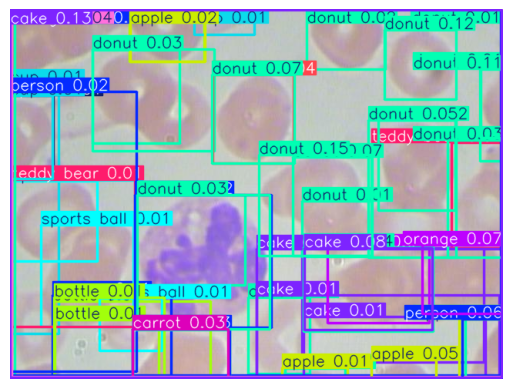

In [ ]:
idx = 44
confianza = 0.005

DST     = Path("datasets/BCCD")
test_imgs_list = sorted((DST/"images/val").glob("*.jpg"))
test_img = str(test_imgs_list[idx])
print("usando la imagen de prueba:", test_img)
# pre-entrenado (probablemente no detecta nada)
res0 = model_coco(test_img, conf=confianza)[0]
plt.imshow(cv2.cvtColor(res0.plot(), cv2.COLOR_BGR2RGB)); plt.axis('off')

## 4. Re-entrenemos YOLO para este dataset (Fine-tuning)

### 4.1 Leamos algunos argumentos de la función train
| Argumento | Valor usado | Descripción |
|-----------|-------------|-----------------------------------------|
| `data`    | `"bccd.yaml"` | Apunta al YAML del dataset. Incluye rutas a los splits, número (`nc`) y nombres de clases. |
| `epochs`  | `EPOCHS` (p. ej. `50`) | Pasadas completas por el set de entrenamiento. Más epochs → mejor convergencia; se detiene antes si hay *early-stopping*. |
| `imgsz`   | `640` px | Re-escala la imagen manteniendo aspecto y luego hace *letterbox* hasta 640 × 640 (relleno negro). Ajusta la resolución de entrada: 640 es equilibrio entre detalle y VRAM. |
| `batch`   | `16` | Nº de imágenes por lote. Demasiado grande → “CUDA out of memory”; demasiado pequeño → entrenamiento inestable. |
| `name`    | `FT_RUN` | Etiqueta para el experimento. Crea la carpeta `runs/detect/FT_RUN/`. |
| `patience`| `10` | Nº de epochs sin mejora en mAP antes de activar *early-stopping*. Ahorra tiempo y evita sobreajuste. |
| `optimizer` | `"SGD"` | Algoritmo de actualización de pesos (SGD, AdamW, …). SGD es robusto; AdamW suele converger más rápido en datasets pequeños. |
| `device`  | `0` | GPU a usar (`0`, `1`, …) o `"cpu"`. Con `0` Colab usará la GPU asignada. |
| `freeze`  | `10` | El número de capas que deseas congelar. |


In [8]:
for (name, p) in model_coco.model.named_parameters():
    print(f"{name:<40} {tuple(p.shape)}  requires_grad={p.requires_grad}")

model.0.conv.weight                      (16, 3, 3, 3)  requires_grad=False
model.0.conv.bias                        (16,)  requires_grad=False
model.1.conv.weight                      (32, 16, 3, 3)  requires_grad=False
model.1.conv.bias                        (32,)  requires_grad=False
model.2.cv1.conv.weight                  (32, 32, 1, 1)  requires_grad=False
model.2.cv1.conv.bias                    (32,)  requires_grad=False
model.2.cv2.conv.weight                  (32, 48, 1, 1)  requires_grad=False
model.2.cv2.conv.bias                    (32,)  requires_grad=False
model.2.m.0.cv1.conv.weight              (16, 16, 3, 3)  requires_grad=False
model.2.m.0.cv1.conv.bias                (16,)  requires_grad=False
model.2.m.0.cv2.conv.weight              (16, 16, 3, 3)  requires_grad=False
model.2.m.0.cv2.conv.bias                (16,)  requires_grad=False
model.3.conv.weight                      (64, 32, 3, 3)  requires_grad=False
model.3.conv.bias                        (64,)  requir

In [9]:
FT_RUN = "y8_bccd_ft"
EPOCHS = 50          # 50 × aprox 150 imgs --> 5-7 min en GPU T4

model_ft = YOLO("yolov8n.pt")   # reutilizamos base COCO
model_ft.train(
    data       = "bccd.yaml",
    epochs     = EPOCHS,
    imgsz      = 640,
    batch      = 16,
    name       = FT_RUN,
    patience   = 10,            # early-stopping
    optimizer  = "SGD",
    device     = 0, # "cpu" si ya no quedan creditos
    freeze     = 22,
)

Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=bccd.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=22, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=y8_bccd_ft, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False,

100%|██████████| 755k/755k [00:00<00:00, 25.7MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,433 parameters, 3,011,417 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.weight'
Freezing layer 'model.2.cv1.bn.bias'
Freezing layer 'model.2.cv2.conv.weight'
Freezing layer 'model.2.cv2.bn.weight'
Freezing layer 'model.2.cv2.bn.bias'
Freezing layer 'model.2.m.0.cv1.conv.weight'
Freezing layer 'model.2.m.0.cv1.bn.weight'
Freezing layer 'model.2.m.0.cv1.bn.bias'
Freezing layer 'model.2.m.0.cv2.conv.weight'
Freezing layer 'model.2.m.0.cv2.bn.weight'
Freezing layer 'model.2.m.0.cv2.bn.bias'
Freezing layer 'model.3.conv.weight'
Freezing layer 'model.3.bn.weight'
Freezing layer 'model.3.bn.bias'
Freezing layer 'model.4.cv1.conv.weight'
Freezing layer 'mode

100%|██████████| 5.35M/5.35M [00:00<00:00, 116MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 854.4±333.0 MB/s, size: 20.1 KB)


train: Scanning /content/datasets/BCCD/labels/train... 291 images, 0 backgrounds, 0 corrupt: 100%|██████████| 291/291 [00:00<00:00, 2274.17it/s]

train: New cache created: /content/datasets/BCCD/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 469.4±240.0 MB/s, size: 20.7 KB)


val: Scanning /content/datasets/BCCD/labels/val... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<00:00, 1496.55it/s]

val: New cache created: /content/datasets/BCCD/labels/val.cache


Plotting labels to runs/detect/y8_bccd_ft/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/y8_bccd_ft
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.21G      1.488      2.818       1.53         55        640: 100%|██████████| 19/19 [00:06<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]

                   all         73        964     0.0119      0.317      0.229      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/50      1.22G      1.359      1.897      1.447         46        640: 100%|██████████| 19/19 [00:03<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


                   all         73        964      0.229      0.387      0.374      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.23G      1.336      1.698      1.455         58        640: 100%|██████████| 19/19 [00:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         73        964     0.0218      0.648      0.394      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.23G        1.3      1.579      1.434         40        640: 100%|██████████| 19/19 [00:03<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

                   all         73        964      0.845      0.357      0.522      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.24G      1.311      1.526      1.441         38        640: 100%|██████████| 19/19 [00:04<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]

                   all         73        964      0.568      0.372       0.58      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.25G      1.282      1.451      1.405         56        640: 100%|██████████| 19/19 [00:03<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

                   all         73        964      0.649      0.539      0.633      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.26G      1.277      1.393      1.399         96        640: 100%|██████████| 19/19 [00:03<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


                   all         73        964      0.646      0.625      0.656      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.26G      1.266      1.353      1.399         63        640: 100%|██████████| 19/19 [00:04<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

                   all         73        964      0.628      0.697      0.731      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.27G      1.248      1.302      1.373         79        640: 100%|██████████| 19/19 [00:03<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]

                   all         73        964      0.652      0.701      0.746      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.28G      1.251      1.305      1.381         81        640: 100%|██████████| 19/19 [00:04<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all         73        964      0.645      0.726      0.759      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.29G      1.248      1.288      1.383         70        640: 100%|██████████| 19/19 [00:03<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]

                   all         73        964      0.683      0.669      0.756      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.29G      1.253      1.269      1.377         89        640: 100%|██████████| 19/19 [00:03<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         73        964      0.646      0.744      0.762       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       1.3G      1.243      1.253      1.376         51        640: 100%|██████████| 19/19 [00:04<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         73        964       0.72       0.72      0.769      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       1.3G      1.241      1.247      1.375        107        640: 100%|██████████| 19/19 [00:03<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]

                   all         73        964      0.763       0.71      0.789      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.31G      1.243      1.238       1.38         56        640: 100%|██████████| 19/19 [00:04<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all         73        964      0.715      0.781      0.796      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.32G      1.226      1.218      1.355        116        640: 100%|██████████| 19/19 [00:03<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         73        964      0.749      0.726      0.789      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.33G      1.209      1.174      1.357         56        640: 100%|██████████| 19/19 [00:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

                   all         73        964      0.743      0.725      0.785       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.33G      1.246      1.215      1.387         56        640: 100%|██████████| 19/19 [00:04<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]

                   all         73        964      0.699       0.78      0.807      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.34G       1.24      1.191      1.375         34        640: 100%|██████████| 19/19 [00:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

                   all         73        964      0.753       0.66      0.794      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.35G      1.217      1.157      1.355         66        640: 100%|██████████| 19/19 [00:03<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         73        964       0.82       0.66      0.819      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.36G      1.214      1.166      1.362         71        640: 100%|██████████| 19/19 [00:03<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]

                   all         73        964      0.739      0.737      0.815      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.36G      1.202       1.15      1.354         80        640: 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.67it/s]

                   all         73        964      0.742      0.765      0.819      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.37G      1.199      1.129      1.343         84        640: 100%|██████████| 19/19 [00:04<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]

                   all         73        964      0.751      0.753      0.811      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.38G      1.194      1.131      1.343         63        640: 100%|██████████| 19/19 [00:03<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

                   all         73        964      0.816      0.746      0.831      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.38G      1.197      1.119      1.352         79        640: 100%|██████████| 19/19 [00:03<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


                   all         73        964      0.722      0.817      0.828      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.39G      1.211       1.11      1.357         68        640: 100%|██████████| 19/19 [00:04<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]

                   all         73        964      0.746       0.77      0.824       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       1.4G      1.217       1.14      1.381         40        640: 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]

                   all         73        964      0.762      0.742      0.827      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.41G      1.188      1.107      1.352         54        640: 100%|██████████| 19/19 [00:04<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         73        964      0.792      0.725       0.84       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.41G      1.212      1.117       1.35        128        640: 100%|██████████| 19/19 [00:03<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]

                   all         73        964       0.69      0.744      0.819      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.42G      1.193      1.105      1.356         37        640: 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.19it/s]

                   all         73        964       0.76      0.748       0.84      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.43G      1.193      1.103      1.341         53        640: 100%|██████████| 19/19 [00:04<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]

                   all         73        964      0.746      0.784      0.825      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.44G      1.189      1.096      1.337         80        640: 100%|██████████| 19/19 [00:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]

                   all         73        964      0.756      0.781      0.842      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.44G       1.19      1.094      1.339         40        640: 100%|██████████| 19/19 [00:03<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all         73        964      0.708      0.775       0.84      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.45G      1.184      1.096      1.342         44        640: 100%|██████████| 19/19 [00:04<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]

                   all         73        964      0.729      0.774      0.837      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.46G       1.19        1.1      1.347         61        640: 100%|██████████| 19/19 [00:03<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]

                   all         73        964      0.783      0.754      0.838      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.46G      1.164      1.073      1.323         54        640: 100%|██████████| 19/19 [00:04<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         73        964      0.773      0.805      0.848      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.47G      1.192       1.08      1.344        105        640: 100%|██████████| 19/19 [00:03<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         73        964      0.784      0.783      0.845      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.48G      1.175      1.058      1.327        157        640: 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]

                   all         73        964      0.774      0.795       0.85      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.48G      1.173      1.068      1.332         75        640: 100%|██████████| 19/19 [00:04<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

                   all         73        964       0.77      0.809      0.838      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.49G      1.182      1.064      1.337         96        640: 100%|██████████| 19/19 [00:03<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

                   all         73        964      0.773      0.813      0.834      0.531


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       1.5G       1.16      1.111      1.348         51        640: 100%|██████████| 19/19 [00:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

                   all         73        964      0.754      0.807      0.838      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       1.5G      1.136      1.031      1.307         40        640: 100%|██████████| 19/19 [00:03<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]

                   all         73        964      0.742        0.8      0.837      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.51G      1.139      1.021      1.328         33        640: 100%|██████████| 19/19 [00:03<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

                   all         73        964      0.754      0.825       0.84      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.52G       1.14      1.022      1.318         33        640: 100%|██████████| 19/19 [00:04<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]

                   all         73        964      0.749      0.797      0.849      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.53G      1.125      1.008      1.311         42        640: 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]

                   all         73        964       0.76      0.825      0.865      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.54G      1.125      1.011      1.313         41        640: 100%|██████████| 19/19 [00:03<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


                   all         73        964      0.775       0.82      0.864      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.54G      1.143      1.014      1.333         40        640: 100%|██████████| 19/19 [00:04<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]

                   all         73        964      0.778       0.81      0.861      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.55G      1.149      1.006      1.335         44        640: 100%|██████████| 19/19 [00:03<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

                   all         73        964      0.789      0.805      0.863      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.55G      1.125     0.9966      1.303         36        640: 100%|██████████| 19/19 [00:03<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


                   all         73        964      0.765      0.831      0.866      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.56G      1.129     0.9992      1.318         42        640: 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

                   all         73        964      0.772      0.818      0.866      0.548



50 epochs completed in 0.070 hours.
Optimizer stripped from runs/detect/y8_bccd_ft/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/y8_bccd_ft/weights/best.pt, 6.2MB

Validating runs/detect/y8_bccd_ft/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


                   all         73        964      0.765       0.83      0.866      0.548
                   RBC         69        821      0.674       0.84      0.828      0.563
                   WBC         71         72      0.882      0.833      0.941      0.663
             Platelets         40         71      0.739      0.817      0.829      0.417
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/detect/y8_bccd_ft


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e943e69ed90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

# 5. Calculemos el mAP en los datos de validación

In [11]:
metrics = model_ft.val(data="bccd.yaml", imgsz=640, split="val")
print("mAP@0.5 luego de FT:", metrics.box.map50)

Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 578.1±107.4 MB/s, size: 19.5 KB)


val: Scanning /content/datasets/BCCD/labels/val.cache... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


                   all         73        964      0.782      0.823      0.866      0.547
                   RBC         69        821      0.679      0.832      0.828      0.564
                   WBC         71         72      0.908      0.819      0.941      0.663
             Platelets         40         71      0.759      0.817      0.829      0.414
Speed: 3.9ms preprocess, 10.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/y8_bccd_ft3
mAP@0.5 luego de FT: 0.8661380807873176


# 5. Visualicemos resultados

usando la imagen de prueba: datasets/BCCD/images/train/BloodImage_00034.jpg

image 1/1 /content/datasets/BCCD/images/train/BloodImage_00034.jpg: 480x640 4 RBCs, 2 WBCs, 1 Platelets, 10.2ms
Speed: 2.1ms preprocess, 10.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

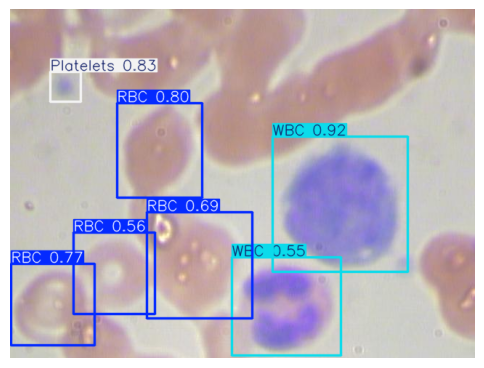

In [14]:
idx = 22
confianza = 0.5

FT_RUN = "y8_bccd_ft"

DST     = Path("datasets/BCCD")
test_imgs_list = sorted((DST/"images/train").glob("*.jpg"))
test_img = str(test_imgs_list[idx])
print("usando la imagen de prueba:", test_img)

best = f"runs/detect/{FT_RUN}/weights/best.pt"
detector = YOLO(best)

res1 = detector(test_img, conf=confianza)[0]
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(res1.plot(), cv2.COLOR_BGR2RGB)); plt.axis('off')